# Dataset Preparation

In [48]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image

In [49]:
p = Path("Images/")

In [50]:
print(p)

Images


In [51]:
dirs = p.glob('*')

In [52]:
p = Path("Images/")
dirs = p.glob('*')

labelsDict = {
    "cat": 0,
    "dog": 1,
    "horse": 2,
    "human": 3
}

imageData = []
imageLabels = []

for dirName in dirs:
    label = str(dirName).split("/")[-1][:-1]
    if label[0] != '.':
        for imgPath in dirName.glob('*.jpg'):
            img = image.load_img(imgPath, target_size=(32, 32))
            imgArr = image.img_to_array(img)
            imageData.append(imgArr)
            imageLabels.append(labelsDict[label])


In [53]:
len(imageData), len(imageLabels)

(808, 808)

## Convert to numpy arrays and shuffling the data

In [54]:
imageData = np.array(imageData, dtype="float") / 255.0
imageLabels = np.array(imageLabels, dtype="int")

In [55]:
imageData.shape, imageLabels.shape

((808, 32, 32, 3), (808,))

In [56]:
import random

In [57]:
combinedData = list(zip(imageData, imageLabels))

In [58]:
random.shuffle(combinedData)

In [59]:
imageData[:], imageLabels[:] = zip(*combinedData)

In [60]:
imageData.shape, imageLabels.shape

((808, 32, 32, 3), (808,))

## Visualizing the data

In [61]:
def drawImage(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

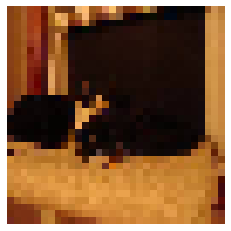

0


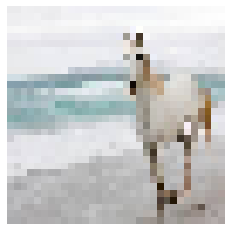

2


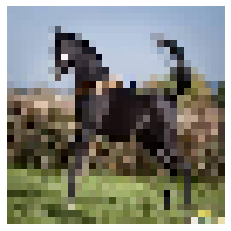

2


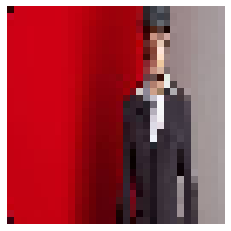

3


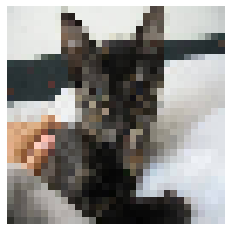

0


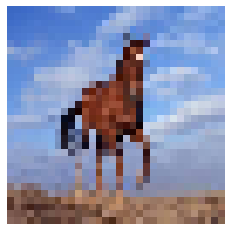

2


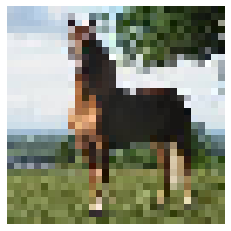

2


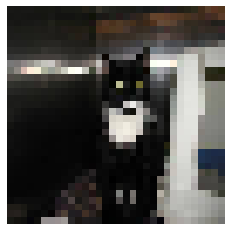

0


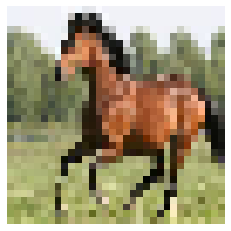

2


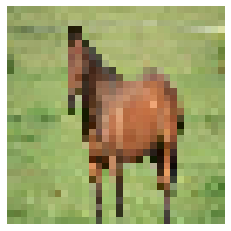

2


In [62]:
for i in range(10):
    drawImage(imageData[i])
    print(imageLabels[i])

# SVM Classifier

In [63]:
class SVM:
    
    def __init__(self, C=1.0):
        # penalty parameter C
        self.C = C
        # weights used for the hyperplane
        self.W = 0
        # bias used for the hyperplane
        self.b = 0
    
    def hingeLoss(self, W, b, X, y):
        # hinge loss function
        loss = 0.0
        loss += .5 * np.dot(W, W.T)

        for i in range(X.shape[0]):
            ti = y[i] * (np.dot(W, X[i].T) + b)
            loss += self.C * max(0, 1 - ti)
        
        return loss[0][0]

    def fit(self, X, y, batchSize=100, learningRate=0.001, maxIter=1000):
        noOfFeatures = X.shape[1]
        noOfSamples = X.shape[0]

        n = learningRate
        c = self.C

        # training
        # initialize weights and bias (model parameters)
        w = np.zeros((1, noOfFeatures))
        bias = 0

        # array to store the loss values
        losses = []

        # training loop
        for i in tqdm(range(maxIter)):

            loss = self.hingeLoss(w, bias, X, y)
            losses.append(loss)
            ids = np.arange(noOfSamples)
            np.random.shuffle(ids)

            # batch gradient descent with random shuffling
            for batchStart in range(0, noOfSamples, batchSize):
                # assuming 0 gradient for the batch
                gradWeights = 0.0
                gradBias = 0.0

                # iterate over all examples in the batch
                for j in range(batchStart, batchStart + batchSize):
                    if j < noOfSamples:
                        # get the index of the example
                        idx = ids[j]

                        # get the label of the example
                        yi = y[idx]

                        ti = yi * (np.dot(w, X[idx].T) + bias)

                        # calculate the gradient (only update if less than 1)
                        if ti < 1:
                            gradWeights += c * yi * X[idx]
                            gradBias += c * yi

                # update the weights and bias with the gradient found above
                w = w - (learningRate * w) + (learningRate * gradWeights)
                bias = bias + (learningRate * gradBias)
        
        self.W = w
        self.b = bias

        return w, bias, losses

## Convert the binary classification problem to a multiclass classification problem by using 1 vs 1 classifiers

In [64]:
image_flattened = imageData.reshape(imageData.shape[0], -1)

In [65]:
image_flattened.shape

(808, 3072)

In [66]:
numClasses = len(np.unique(imageLabels))

In [67]:
def classWiseData(X, y):
    data = {}
    for i in range(numClasses):
        data[i] = []
    for i in range(X.shape[0]):
        data[y[i]].append(X[i])
    for k in data.keys():
        data[k] = np.array(data[k])
    return data

In [68]:
classwiseData = classWiseData(image_flattened, imageLabels)

In [69]:
classwiseData[0].shape, classwiseData[1].shape, classwiseData[2].shape, classwiseData[3].shape

((202, 3072), (202, 3072), (202, 3072), (202, 3072))

In [70]:
def getDataPair(d1, d2):
    # combines data of 2 classes d1 and d2 into a single array of shape (2*d1.shape[0], d1.shape[1]) for 1 vs 1 classification

    l1, l2 = d1.shape[0], d2.shape[0]
    totalSamples = l1 + l2
    totalFeatures = d1.shape[1]
    dataPair = np.zeros((totalSamples, totalFeatures))
    dataLabels = np.zeros(totalSamples)

    dataPair[:l1, :] = d1
    dataPair[l1:, :] = d2

    dataLabels[:l1] = -1
    dataLabels[l1:] = 1

    return dataPair, dataLabels

# Learining the model weights

In [71]:
svm = SVM()

In [72]:
def trainSVM(X, y):
    svmClassifiers = {}
    for i in range(numClasses):
        svmClassifiers[i] = {}
        for j in range(i+1, numClasses):
            xPair, yPair = getDataPair(classwiseData[i], classwiseData[j])
            wts, bias, losses = svm.fit(xPair, yPair, learningRate=0.00001)
            svmClassifiers[i][j] = (wts, bias)
    return svmClassifiers

In [73]:
classifiers = trainSVM(image_flattened, imageLabels)

100%|██████████| 1000/1000 [00:22<00:00, 44.68it/s]


In [74]:
catsDogs = classifiers[0][1]

In [75]:
# weights
catsDogs[0].shape

(1, 3072)

In [76]:
# bias
catsDogs[1]

0.020560000000000057

# Prediction

In [77]:
def binaryPredict(X, w, b):
    # predicts the class of the input X
    y_ = np.dot(X, w.T) + b
    if y_ >= 0:
        return 1
    else:
        return -1
    # return np.sign(np.dot(X, w.T) + b)

In [78]:
def predict(X):
    count = np.zeros(numClasses)
    for i in range(numClasses):
        for j in range(i+1, numClasses):
            wts, bias = classifiers[i][j]
            # take majority prediction from each of the classifiers
            y_ = binaryPredict(X, wts, bias)
            if y_ == 1:
                count[j] += 1
            else:
                count[i] += 1
    pred = np.argmax(count)
    return pred

In [79]:
def getAccuracy(X, y):
    count = 0
    for i in range(X.shape[0]):
        pred = predict(X[i])
        if pred == y[i]:
            count += 1
    return count*100 / X.shape[0]

In [80]:
getAccuracy(image_flattened, imageLabels)

61.50990099009901

## Sklearn implementation

In [81]:
from sklearn import svm

In [82]:
svm = svm.SVC(kernel='linear', C=1.0)

In [83]:
svm.fit(image_flattened, imageLabels)

SVC(kernel='linear')

In [84]:
svm.score(image_flattened, imageLabels)

0.6571782178217822